                                                Initial Setup

In [1]:
import numpy as np
import os, sys, math, csv, xlwt
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
from xlwt import Workbook 
%matplotlib inline
np.set_printoptions(threshold=np.nan)


In [2]:
#define things about the cutouts
cutout_directory = 'kn07_cuts/' # location for image cutouts. currently running on only 100ish images

star_location_x =810
star_location_y =2757
size=200
cutout_x_start = int(star_location_x-size/2)
cutout_x_stop = int(star_location_x+size/2)
cutout_y_start = int(star_location_y-size/2)
cutout_y_stop = int(star_location_y+size/2)

                                      Creating Image Cutouts ~RUN ONLY ONCE~

In [3]:
#define things about large images
initial_directory = '/Users/Olive/Desktop/kn07_files/' # path of directory that contains full image fits files

all_files=os.listdir(initial_directory) #extract list of files
file_count = len(all_files) # gives number of files in directory
sort_files = sorted(all_files) # sort directory in alphanumeric order
full_img_list = [os.path.join(initial_directory, sort_files[i]) for i in range(0,file_count)] # create file path names for full image files

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/Olive/Desktop/kn07_files/'

In [ ]:
#RUN ONLY ONCE TO CREATE CUTOUTS
# a loop to create image cutouts
for i in range(0,file_count):
  #extract data
    full_Image_Data = fits.getdata(full_img_list[i]) #take out data from file (pixel values are in 'section' 1)
    full_Image_Header= fits.getheader(full_img_list[i], ext=1)
  #collect only necessary data
    cutout_data= full_Image_Data[cutout_y_start:cutout_y_stop, cutout_x_start:cutout_x_stop]  #choose area of data to keep
  #save the image
    cutoutName='cutout_'+all_files[i][len(all_files[i])-20:] #appends 'cutout' to the date and id of photo
    destination=cutout_directory+cutoutName  #define destination of new file
    fits.writeto(destination, cutout_data, full_Image_Header)  #save fits file    
print('done')

                                     Listing Comparison Stars ~RUN ONLY ONCE~

In [56]:
#RUN ONLY ONCE to create a file of stars that are potential candidates for comparison stars to the target
b=open("07comparison_stars.txt","w+")
b.write("x_coord y_coord brightness distance")

x_coord, y_coord, brightness, = np.loadtxt("07_east.dat",unpack=True,usecols=(0,1,3))

with open("07_east.dat", "r") as f:
    Bright_List=[]
    lines = f.readlines()
    i=1
    while i < len(x_coord):
        if i != 0:           
            x_coord_now, y_coord_now, brightness_now=x_coord[i], y_coord[i], brightness[i]    
            Diff_X = abs(float(star_location_x) - float(x_coord_now))
            Diff_Y = abs(float(star_location_y) - float(y_coord_now))  
            
            if Diff_X <= size/2 and Diff_Y <= size/2: 
                distance = math.sqrt(((abs(Diff_X))**2)+abs((Diff_Y)**2))
                Bright_List.append([x_coord_now,y_coord_now,brightness_now,round(distance,3)])
        i += 1

    Bright_List.sort(key = lambda x: x[2]) 
    Bright_List_trimmed = Bright_List[0:20]  
   
    b.write('\n')
    for j in Bright_List_trimmed: 
        for k in j:
            b.write(str(k))
            b.write(' ')
        b.write('\n')  

                             Creating cutout list and collecting data

In [4]:
# create file path names for cutout image files

cut_files=os.listdir(cutout_directory) #extract list of files
file_count = len(cut_files) # gives number of files in directory
sort_files = sorted(cut_files) # sort directory in alphanumeric order
cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]

open_cutouts =[]
for i in range (0,file_count):
    image=fits.open(cutout_img_list[i]) #open file
    imageData = image[0].data  #take out data from file (data is in 'section' 1)
    image.close()
    open_cutouts.append(imageData)

In [5]:
# define comparison star coordinates and radii from an existing text file 

comparison_stars= np.loadtxt('07comparison_stars.txt', skiprows=1)
comparison_star_circles= [] # empty list for background star circles

for i in range(len(comparison_stars)):
    newStar = comparison_stars[i] #ientify row for clearer use in the next line
    comparison_star_location_x= newStar[0]
    comparison_star_location_y= newStar[1]
    
    # calculate location in terms of local pixels
    location_in_cutout_x= int(round(size/2+(comparison_star_location_x-star_location_x)))
    location_in_cutout_y= int(round(size/2+(comparison_star_location_y-star_location_y)))
    
    # create list of circles to plot
    comparison_star_circles.append(circle((location_in_cutout_x,location_in_cutout_y-1), r=3)) 

In [27]:
#write star fluxes into txt files, including main star
#~~~~~~NEW~~~~~~~
#~ ~ ~ R U N   O N L Y   O N C E ~ ~ ~

# make table files
comp_star_tables=[]
for j in range(0, len(comparison_star_circles)):  
    star_file= open("star_tables/comparison_star_"+str(j)+".txt","w+")
    star_file.write("time flux clip")
    comp_star_tables.append("comp_star_tables/comparison_star_"+str(j)+".txt")

#main star table
star_tables=[]
Mstar_file= open("star_tables/main_star.txt","w+")
Mstar_file.write("time flux clip")
star_tables.append("comp_star_tables/comparison_star_"+str(j)+".txt")
star_tables.append(comp_star_tables)

#loop over all images
for i in range(0, file_count):
    # 5. extract time from cutout file
    image=fits.open(cutout_img_list[i]) #open file
    time_of_flux = image[0].header['JDT']  #take out data from file (data is in 'section' 1)
    image.close()
    for j in range(0, len(star_tables)):  
        # 3. calculate location in terms of local pixels
        if j==0 :
            location_in_cutout_x= int(round(size/2))
            location_in_cutout_y= int(round(size/2))
            fluxSpace
        else:
            comparison_star_location_x= comparison_stars[j][0]
            comparison_star_location_y= comparison_stars[j][1]
            location_in_cutout_x= int(round(size/2+(comparison_star_location_x-star_location_x)))
            location_in_cutout_y= int(round(size/2+(comparison_star_location_y-star_location_y)))
            fluxSpace=comparison_star_circles[j]
            
        # 4. calculate flux with 'photometry' function for each cutout
        flux_of_star=photometry(open_cutouts[i], fluxSpace, method = 'exact') 
        
        # 6. write as flux and time table text file
        with open(star_tables[j], 'a') as file:
            file.write("\n" + str(time_of_flux) +" "+ str(flux_of_star[0][3])+" 1")

with open(star_tables, 'a') as file:
    file.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709


In [61]:
print(comp_star_tables)

['comparison_star_0.txt', 'comparison_star_1.txt', 'comparison_star_10.txt', 'comparison_star_11.txt', 'comparison_star_12.txt', 'comparison_star_13.txt', 'comparison_star_14.txt', 'comparison_star_15.txt', 'comparison_star_16.txt', 'comparison_star_17.txt', 'comparison_star_18.txt', 'comparison_star_19.txt', 'comparison_star_2.txt', 'comparison_star_3.txt', 'comparison_star_4.txt', 'comparison_star_5.txt', 'comparison_star_6.txt', 'comparison_star_7.txt', 'comparison_star_8.txt', 'comparison_star_9.txt']


In [62]:
#if not comp_star_tables:
print('making list')
comp_star_tables=os.listdir("comp_star_tables/") #extract list of files
table_count = len(comp_star_tables) # gives number of files in directory
table_list = [os.path.join("comp_star_tables/", comp_star_tables[i]) for i in range(0,table_count)] # create file path names for full image files
table_list.sort(key=len)
#else:
#    print('it exists')
print(table_list)

making list
['comp_star_tables/comparison_star_0.txt', 'comp_star_tables/comparison_star_1.txt', 'comp_star_tables/comparison_star_2.txt', 'comp_star_tables/comparison_star_3.txt', 'comp_star_tables/comparison_star_4.txt', 'comp_star_tables/comparison_star_5.txt', 'comp_star_tables/comparison_star_6.txt', 'comp_star_tables/comparison_star_7.txt', 'comp_star_tables/comparison_star_8.txt', 'comp_star_tables/comparison_star_9.txt', 'comp_star_tables/comparison_star_10.txt', 'comp_star_tables/comparison_star_11.txt', 'comp_star_tables/comparison_star_12.txt', 'comp_star_tables/comparison_star_13.txt', 'comp_star_tables/comparison_star_14.txt', 'comp_star_tables/comparison_star_15.txt', 'comp_star_tables/comparison_star_16.txt', 'comp_star_tables/comparison_star_17.txt', 'comp_star_tables/comparison_star_18.txt', 'comp_star_tables/comparison_star_19.txt']


In [12]:
def mean(Array):
    total_flux=0
    num_of_fluxes=0
    for i in range(0, len(Array)):
        if Array[i][2] == 1:
            total_flux +=Array[i][1]
            num_of_fluxes +=Array[i][2]
    return total_flux/num_of_fluxes

def RMS(mean, array):
    diff= []
    for x in range(0,len(array)):
        if array[x][2] == 1:
            diff.append((((array[x][1]-mean)/len(array))**2)**(1/2))
    return sum(diff)

In [13]:
# root mean square equation

number_of_clippings = 4 
clipping_treshold = 3 #multiples of RMS
table_mean_RMS=[]

#calculate mean and RMS of all stars
for i in range(table_count):
    fluxes=[]    
    #read data of table to an array
    with open(table_list[i]) as infile:
        line1= True
        for line in infile:
            if line1 == False: 
                fluxes.append([float(line.split()[0]),float(line.split()[1]), int(line.split()[2])])
            line1= False
    #clip 'number_of_clippings' amount of times
    for clip in range(0, number_of_clippings):
        mean_i = mean(fluxes)
        RMS_i = RMS(mean_i, fluxes)
        #loop through list and remove whatever is outside the range
        for x in range(0, len(fluxes)):
            if abs(fluxes[x][1]-mean_i)>(clipping_treshold*RMS_i):
                fluxes[x][2] = 0

    #create table with stars and their MEAN and RMS
    table_mean_RMS.append([i, table_list[i],mean_i,RMS_i])
    
    #rewrite file to have 0 values
    star_file= open("comp_star_tables/comparison_star_"+str(i)+".txt","w+")
    star_file.write("time flux clip")
    for j in range(0, len(fluxes)):
        star_file.write("\n" + str(fluxes[j][0]) +" "+ str(fluxes[j][1])+" "+ str(fluxes[j][2]))
    star_file.close()

In [15]:
import operator

def sort_table(table, col):
    return sorted(table, key=operator.itemgetter(col))

def removeCompStars(array, amountKept, table):
    comparison_star_circles=[]
    for num in range (0, amountKept):
        circle_to_add=table_mean_RMS[num][0]    
        comparison_star_circles.append(array[circle_to_add])
    return comparison_star_circles

num_stars_kept=10

table_mean_RMS= sort_table(table_mean_RMS,3)
comparison_star_circles=removeCompStars(comparison_star_circles, num_stars_kept, table_mean_RMS)

IndexError: list index out of range

                              ~  Light Curve and Phase Curve Production ~

                                     Producing Reference Images

In [16]:
# variables for the graphs

display_file = 0 # target file number to display target image. It can stay hardcoded, it's only for our reference

x_aperture = 9 # x coordinate of target aperture center within the star cutout 
y_aperture = 11 # y coordinate of target aperture center within the star cutout 
r = 3 # radius of target aperture

x_background = x_aperture # x coordinate of background annulus center
y_background = y_aperture # y coordinate of background annulus center
r_in = 8 # inner radius of background annulus (in pixels)
r_out = r_in + 1 # outer radius of background annulus

#a size large enough for the background annulus with 2px of padding on each side
target_img_size= (r_out+2)*2 # x by x pixel size of target image

low_period = 1.5 # lowest period for LombScargle to test on target star (days)
high_period = 500# highest period for LombScargle to test on target star (days)

In [17]:
#define placement of main star apreture on images

center = size/2 # calculate center location of target image
target = open_cutouts[display_file][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] # create array of target image data values for specified file
aperture_main_cutout = circle((x_aperture,y_aperture), r) # create circular aperture around target
background_main_cutout = annulus((x_background,y_background), r_in, r_out) # create annulus for background flux

#place aperture and annulus of main star on large image
offset = (len(open_cutouts[display_file])-target_img_size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture_large_cutout = circle((x_aperture+offset,y_aperture+offset), r) # place aperture on target star in comparison stars image
background_large_cutout = annulus((x_background+offset,y_background+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image

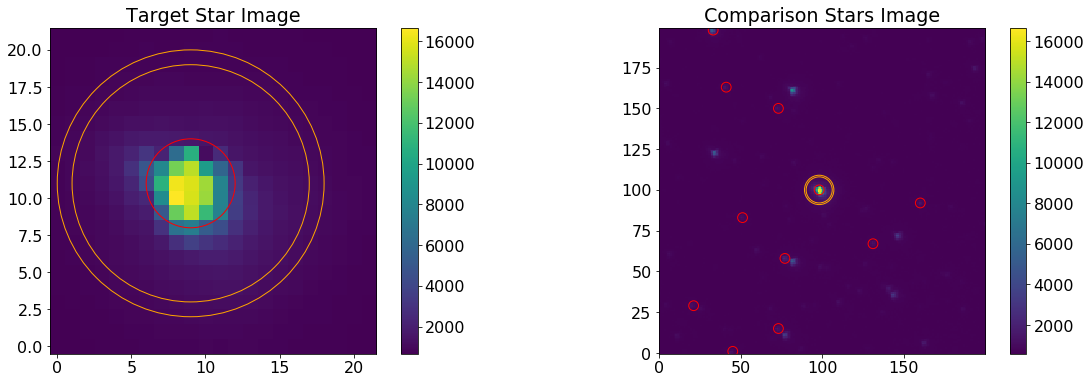

In [18]:
# create target image with target aperture and background annulus
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

def target_star_image():
    plt.subplot(121)
    plt.title('Target Star Image')
    plt.imshow(target, origin='lower')
    plt.colorbar()
    aperture_main_cutout.plot(color='red')
    background_main_cutout.plot(color='orange')

# create comparison stars image with target aperture, comparison apertures, and background annulus
def comparison_star_image():
    plt.subplot(122)
    plt.title('Comparison Stars Image')
    plt.imshow(open_cutouts[display_file], origin='lower')
    plt.colorbar()
    aperture_large_cutout.plot(color='red')
    background_large_cutout.plot(color='orange')
    for i in range(len(comparison_star_circles)):
        comparison_star_circles[i].plot(color='red')

target_star_image()
comparison_star_image()
plt.show()


                                             Star Flux vs. Time

In [ ]:
time=[]
table=np.loadtxt(table_list[0], skiprows=1)
for line in range(0,len(table)):
    time.append(table[line][0])

In [76]:
#
#might make it graphing time 
beginning_input=int(input ("input beginning date "))
end_input=int(input ("input ending date "))

beginning_timestamp=0
end_timestamp=0
for i in range (0, len(time)):
    if beginning_input <= time[i]:
        beginning_timestamp= i
        break
        
for i in range (beginning_timestamp, len(time)):
    if end_input <= time[i]:
        end_timestamp= i
        break

print(beginning_timestamp)
print(end_timestamp)

input beginning date 2455000
input ending date 2456000
1356
4008


In [70]:
background_mask = background_large_cutout.to_mask(method='center') # create mask over pixels in background annulus that have their centers within the annulus 
background_data = [background_mask[0].multiply(open_cutouts[i]) for i in range(0,file_count)] # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
background_flux = [background_data[i][background_mask[0].data > 0] for i in range(0,file_count)] # create array of flux values contained in mask
background_median = [np.median(background_flux[i]) for i in range(0,file_count)] # find median of background flux array

# create target flux vs. time plot
target_sum = [photometry(open_cutouts[i], aperture_large_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_background_sum = [background_median[i] * aperture_large_cutout.area() for i in range(0,file_count)] # multiply background median by area of aperture to get background flux contained in aperture
target_subtract = np.array([target_sum[i]['aperture_sum'] - target_background_sum[i] for i in range(0,file_count)]) # subtract background flux in aperture from aperture's total flux

target_flux = target_subtract[target_subtract != 0] # disregard zero flux values 
normalized_target_flux = target_flux/max(target_flux)          


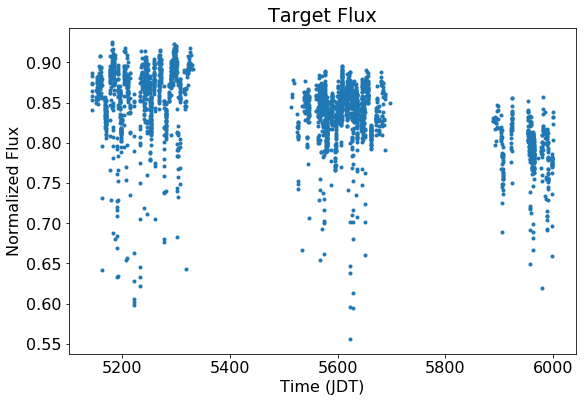

In [77]:
#create flux v. time plot
plt.subplot(121)
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
      
#rounding x tick marks
roundDecimals=2
difference=(max(time)+1-min(time))

while difference>=10:
    difference= difference/10
    roundDecimals=roundDecimals-1
if difference<=1:   
    roundDecimals=roundDecimals-2
    while difference<=1:
        difference= difference/10
        roundDecimals=roundDecimals+1

#plotting    
graphing_time=[time[i]-2450000 for i in range(0,len(time))]
#print(graphing_time)

graphing_time= graphing_time[beginning_timestamp:end_timestamp]
normalized_target_flux= normalized_target_flux[beginning_timestamp:end_timestamp]

def target_star_flux_graph():
    plt.title('Target Flux') 
    #plt.xticks(np.arange(round(min(time),roundDecimals), max(time)+1, round((max(time)+1-min(time))/5,roundDecimals)))
    plt.plot(graphing_time, normalized_target_flux, '.')

target_star_flux_graph()
plt.show()

                                   Comparison Star Flux vs. Time

In [79]:
#graph all stars together

# sum up exact amount of flux contained in each comparison star aperture
comparison_sum = [[photometry(open_cutouts[i], comparison_star_circles[j], method = 'exact') 
                   for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))]

# multiply background median by area of each aperture to get background flux contained in each aperture
comparison_background_sum = [[background_median[i] * comparison_star_circles[j].area() 
                              for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))]

# subtract background flux in each aperture from each aperture's total flux
comparison_subtract = np.array([[comparison_sum[j][i]['aperture_sum'] - comparison_background_sum[j][i] 
                                 for i in range(0,file_count)] for j in range(0,len(comparison_star_circles))]) 

comparison_total = comparison_subtract.sum(axis=0) # sum up the background subtracted flux for all comparison stars
comparison_flux = comparison_total[comparison_total != 0] # disregard zero flux values

normalized_comparison_flux= comparison_flux/max(comparison_flux)


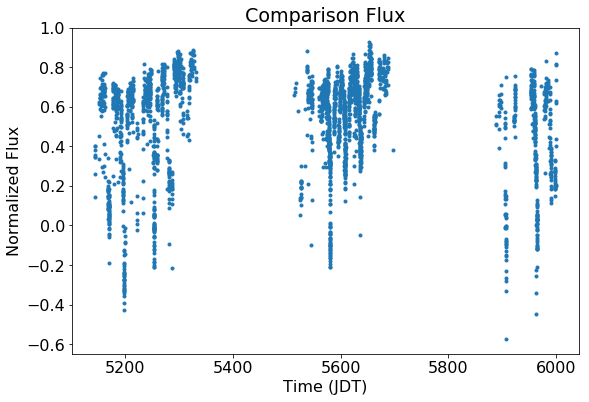

In [81]:
# create comparison flux vs. time plot
plt.subplot(122)
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')

normalized_comparison_flux= normalized_comparison_flux[beginning_timestamp:end_timestamp]
def comparison_stars_flux_graph():
    plt.title('Comparison Flux')
    #plt.xticks(np.arange(round(min(time),roundDecimals), max(time)+1, round((max(time)+1-min(time))/5,roundDecimals)))
    plt.plot(graphing_time, normalized_comparison_flux, '.')
        
comparison_stars_flux_graph()
plt.show()

In [89]:
# subtract target flux from comparison flux then use Lomb-Scargle Periodogram to test period range on target 

final_flux = np.subtract(target_flux, comparison_flux) 
frequency, power = LombScargle(time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 

phase_offset = 0.5 - np.remainder(time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
phase = np.remainder(time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles


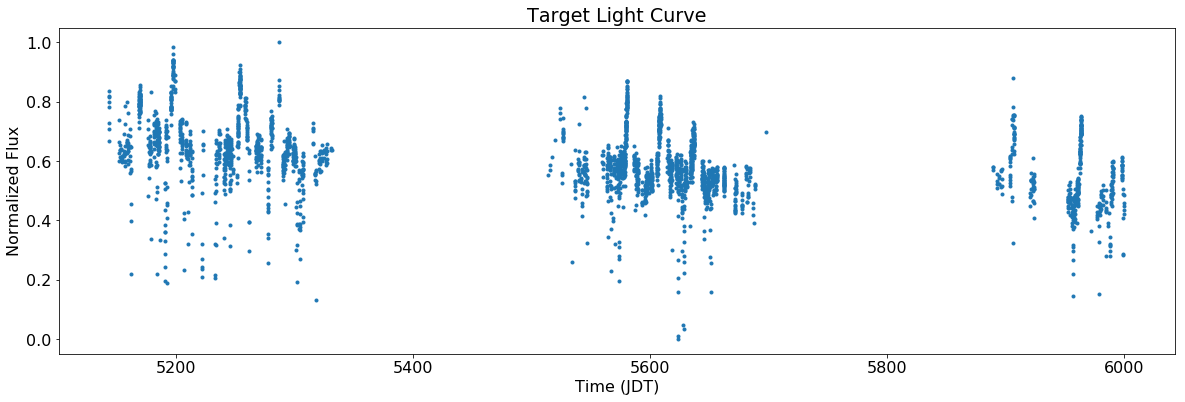

In [90]:
# create target light curve with target flux minus comparison flux vs. time 
plt.title('Target Light Curve')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
#plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))

final_flux= final_flux[beginning_timestamp:end_timestamp]

plt.plot(graphing_time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
plt.show()

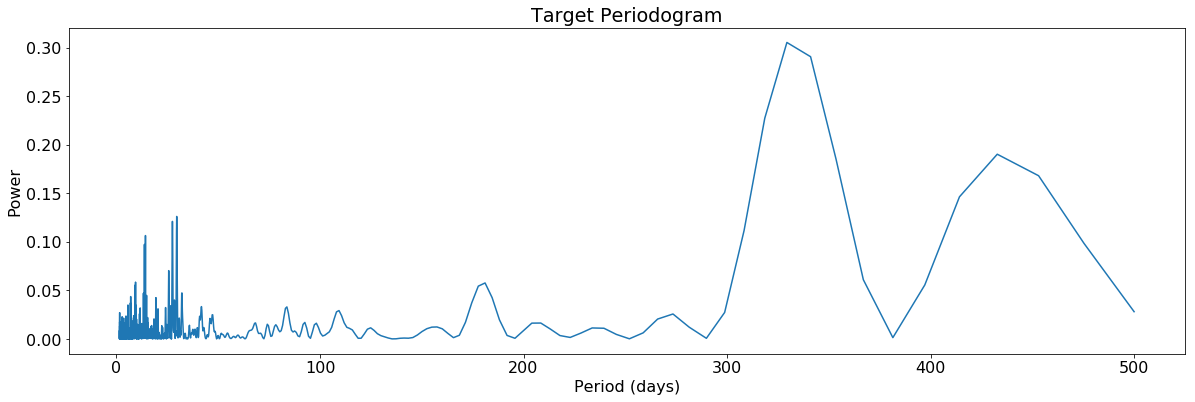

best period for range 1.5 to 500 days = 329.4034678659675 days
power value for best period =  0.305253915560079


In [91]:
# create target periodogram with power vs. period
plt.plot(1/frequency, power)
plt.title('Target Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()
# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

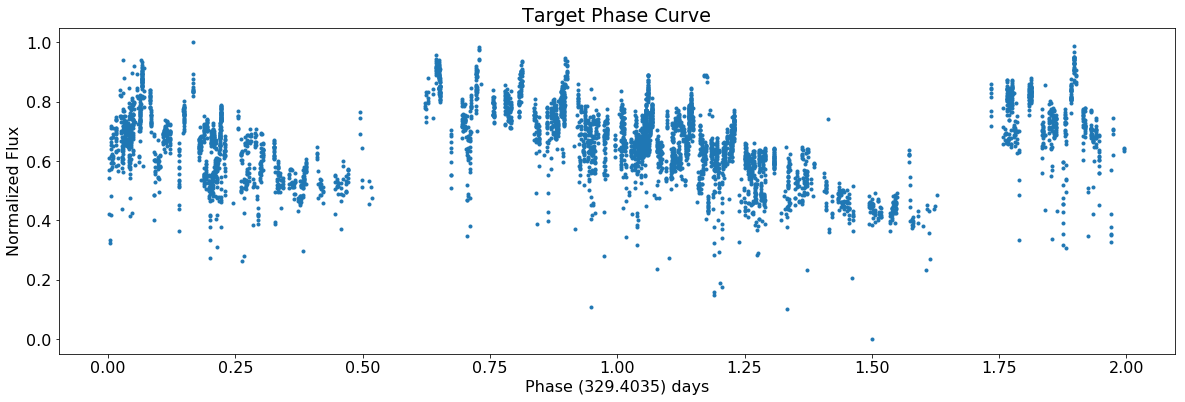

In [60]:
# create target phase curve with flux vs. phase
plt.plot(phase, (final_flux - min(final_flux))/max(final_flux-min(final_flux)), '.')
plt.title('Target Phase Curve')
xLabel= 'Phase ('+ str(round(period,4))+ ') days'
plt.xlabel(xLabel)
plt.ylabel('Normalized Flux')
plt.show()

                                                Creating Flux Histogram

In [22]:
# cell for upcoming variables not previously defined

bin_size = 2500 # bin size for histogram

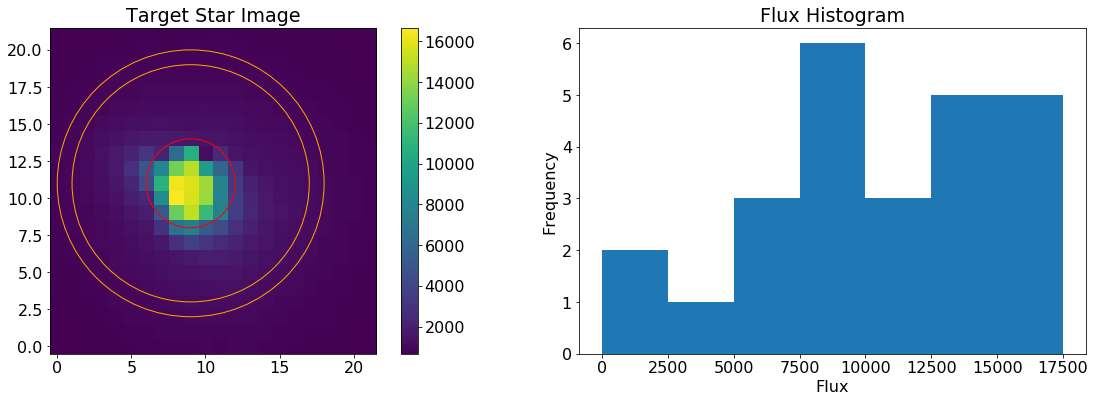

In [23]:
# create target image with target aperture and background annulus


aperture_mask = aperture_main_cutout.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

# create bins for histogram up to highest flux value in aperture
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) 

# create flux histrogram of values within target aperture
plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
target_star_image()
plt.show()

                                            Examining Abnormal Flux Values

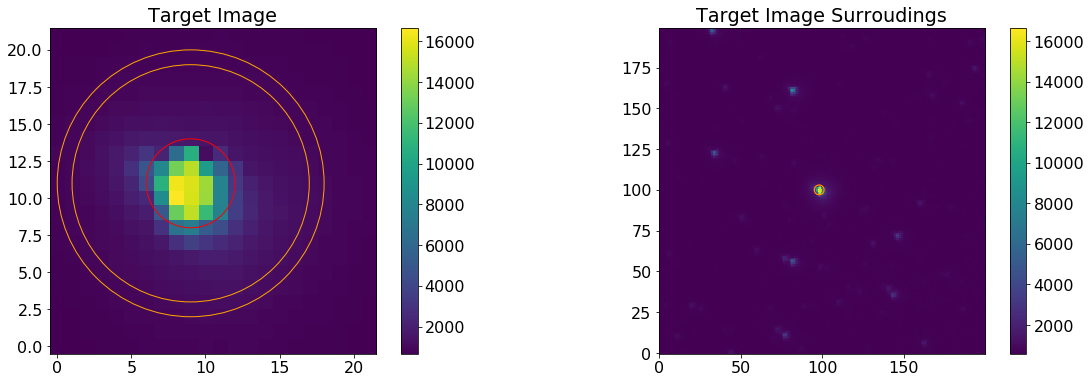

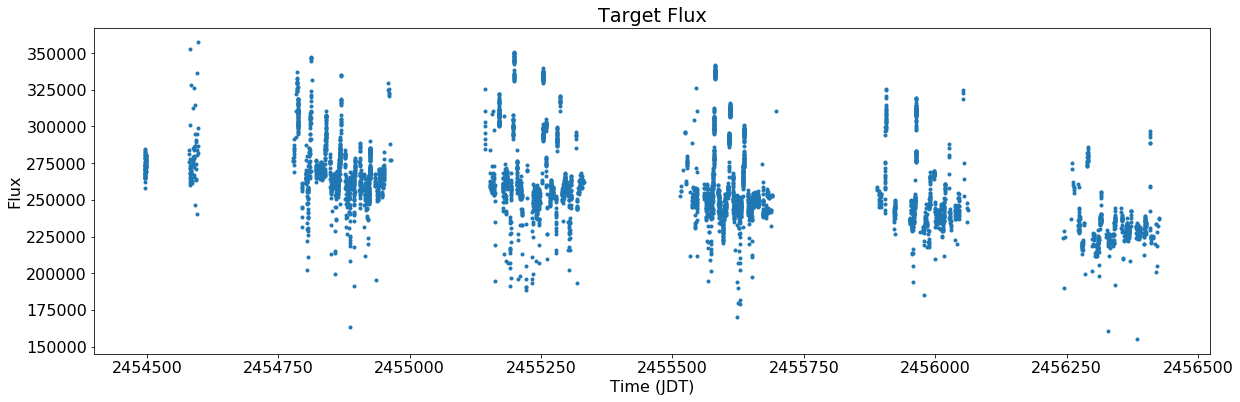

Low Flux Values

File    Target Flux



High Flux Values

File    Target Flux


In [24]:

# create target image with target aperture and background annulus
plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

target_data = [open_cutouts[i][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] for i in range(0,file_count)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture_main_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,file_count)]) # get flux of target aperture without disregarding zero flux values


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(open_cutouts[display_file], origin='lower')
plt.colorbar() 
aperture_large_cutout.plot(color='red') 
aperture_large_cutout.plot(color='orange')
plt.show()

#redefine time to contain timestamps even of 0 flux images
alltime=[]
for i in range(0,len(open_cutouts)):
    cutout_file = fits.open(cutout_img_list[i])
    alltime.append(cutout_file[0].header['JDT'])
    cutout_file.close

# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
#plt.xticks(np.arange(round(min(alltime),-2), max(alltime)+1, round((max(alltime)+1-min(alltime))/10,-2)))
plt.plot(alltime, target_flux, '.')
plt.show()


low_flux = 100000
high_flux = np.inf # upper limit for target flux values


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "        ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "        ", target_flux[target_flux > high_flux][i])